## Training: Fitness Function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *
import torch.nn.functional as F

#### Set seeds

In [15]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

#### Load dataset

In [16]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="data/fitness_function")
test_dataset = DatasetFF(train=False, path="data/fitness_function")

In [17]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0338, -0.0450, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5015,  0.5409, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5015,  0.6049, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5214,  0.3496, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.6650,  0.3553, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.5214,  0.3496, 24.0000]])

In [18]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 0.]])

#### Scale training and test data

In [19]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, 6:])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [20]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -1.5951, -2.0510,  0.0471],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4045,  0.6223,  0.0471],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4045,  0.9142,  0.0471],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.4894, -0.2505,  0.0471],
        [ 0.0000,  1.0000,  0.0000,  ...,  1.1035, -0.2246,  0.0471],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.4894, -0.2505,  0.0471]])

#### Build model and switch to GPU if available

In [21]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[36,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=36, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [22]:
fitness_function(test_dataset.X[0])

tensor([0.8167, 0.5667, 0.3167, 0.0667], grad_fn=<AddBackward0>)

#### Define optimizer and additional measure to report (optional)

In [23]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### Define Data loaders

In [24]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [25]:
n_epochs = 140

# Stuff to store
train_losses = np.zeros(n_epochs)
train_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_maes = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    train_mae = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_mae.append(report_measure(torch.sigmoid(outputs), targets).item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_mae = np.mean(train_mae)

    test_loss = []
    test_mae = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
    test_loss = np.mean(test_loss)
    test_mae = np.mean(test_mae)

    # Save losses
    train_losses[it] = train_loss
    train_maes[it] = train_mae
    test_losses[it] = test_loss
    test_maes[it] = test_mae

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f},'
              f' Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')

Epoch 1/140, Train Loss: 2.7772, Test Loss: 2.4792, Train MAE: 0.4782, Test MAE: 0.4507
Epoch 10/140, Train Loss: 2.0305, Test Loss: 2.0857, Train MAE: 0.3716, Test MAE: 0.3744
Epoch 20/140, Train Loss: 1.8822, Test Loss: 1.9379, Train MAE: 0.3404, Test MAE: 0.3443
Epoch 30/140, Train Loss: 1.7890, Test Loss: 1.8740, Train MAE: 0.3180, Test MAE: 0.3243
Epoch 40/140, Train Loss: 1.7311, Test Loss: 1.8189, Train MAE: 0.3024, Test MAE: 0.3099
Epoch 50/140, Train Loss: 1.6880, Test Loss: 1.7974, Train MAE: 0.2897, Test MAE: 0.2998
Epoch 60/140, Train Loss: 1.6738, Test Loss: 1.7886, Train MAE: 0.2832, Test MAE: 0.2931
Epoch 70/140, Train Loss: 1.6539, Test Loss: 1.7832, Train MAE: 0.2763, Test MAE: 0.2879
Epoch 80/140, Train Loss: 1.6339, Test Loss: 1.7786, Train MAE: 0.2710, Test MAE: 0.2828
Epoch 90/140, Train Loss: 1.6265, Test Loss: 1.8081, Train MAE: 0.2683, Test MAE: 0.2822
Epoch 100/140, Train Loss: 1.6226, Test Loss: 1.8064, Train MAE: 0.2655, Test MAE: 0.2804
Epoch 110/140, Train 


#### Plot the train loss and test loss per iteration

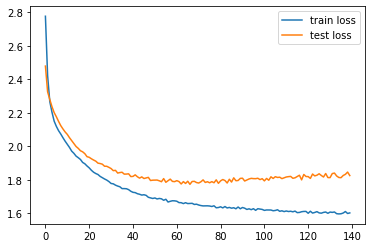

In [26]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

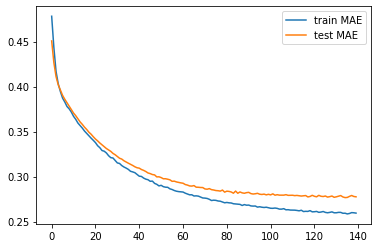

In [27]:
plt.plot(train_maes, label='train MAE')
plt.plot(test_maes, label='test MAE')
plt.legend()
plt.show()

#### Save trained model

In [28]:
torch.save(fitness_function.state_dict(), "models/best_fitness_function_path.pth")

#### Load model and make predictions

In [29]:
model = OrdinalClassifierFNN(num_classes=5, layer_sizes=[36,28])
model.load_state_dict(torch.load("models/best_fitness_function_path.pth"))
model.eval()

OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=36, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [30]:
random_input = torch.from_numpy(np.random.normal(size=[1, 36]).astype(np.float32))

output = model(random_input)

In [31]:
output

tensor([[-3.6023, -5.0306, -6.6092, -8.5487]], grad_fn=<AddBackward0>)

In [32]:
decode_classes(output)

array([[0]])